In [1]:
import pennylane as qml
from pennylane.templates import StronglyEntanglingLayers
from pennylane.qnn import TorchLayer
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time

In [2]:
data = pd.read_csv('../../../Datasets/creditcard.csv')

print(data.head(10))

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   
5   2.0 -0.425966  0.960523  1.141109 -0.168252  0.420987 -0.029728  0.476201   
6   4.0  1.229658  0.141004  0.045371  1.202613  0.191881  0.272708 -0.005159   
7   7.0 -0.644269  1.417964  1.074380 -0.492199  0.948934  0.428118  1.120631   
8   7.0 -0.894286  0.286157 -0.113192 -0.271526  2.669599  3.721818  0.370145   
9   9.0 -0.338262  1.119593  1.044367 -0.222187  0.499361 -0.246761  0.651583   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -

In [3]:
X = data.drop(['Class'], axis=1)
y = data['Class']

X = np.array(X)
y = np.array(y)

print(X.shape)
print(y.shape)

(284807, 30)
(284807,)


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_train = y_train.astype(int)
y_test = y_test.astype(int)

X_train_torch = torch.tensor(X_train, dtype=torch.float32)
y_train_torch = torch.tensor(y_train, dtype=torch.long)
X_test_torch  = torch.tensor(X_test,  dtype=torch.float32)
y_test_torch  = torch.tensor(y_test,  dtype=torch.long)

train_dataset = TensorDataset(X_train_torch, y_train_torch)
test_dataset  = TensorDataset(X_test_torch,  y_test_torch)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False)

In [5]:
def sample_from_train(X_train, y_train, sample_size_for_each_class, batch_size):
    X_train_sampled = []
    y_train_sampled = []

    for class_label in np.unique(y_train):
        class_indices = np.where(y_train == class_label)[0]
        sampled_indices = np.random.choice(class_indices, size=sample_size_for_each_class, replace=False)

        X_train_sampled.extend(X_train[sampled_indices])
        y_train_sampled.extend(y_train[sampled_indices]) 

    X_train_sampled = np.array(X_train_sampled)
    y_train_sampled = np.array(y_train_sampled)

    X_train_sampled_torch = torch.tensor(X_train_sampled, dtype=torch.float32)
    y_train_sampled_torch = torch.tensor(y_train_sampled, dtype=torch.long)

    train_sampled_dataset = TensorDataset(X_train_sampled_torch, y_train_sampled_torch)
    train_sampled_loader = DataLoader(train_sampled_dataset, batch_size=batch_size, shuffle=True)

    return train_sampled_loader  

In [6]:
class QuantumNeuralNetwork:
    def __init__(self, n_qubits, n_layers):
        self.n_qubits = n_qubits
        self.n_layers = n_layers
        self.dev = qml.device('lightning.gpu', wires=range(n_qubits))
        self.qnn_layer = self._create_qnn_layer()
        
    def _create_qnn_layer(self):
        def quantum_circuit(inputs, weights):
            qml.AngleEmbedding(inputs, wires=range(self.n_qubits), rotation='X')
            StronglyEntanglingLayers(weights, wires=range(self.n_qubits))
            return [qml.expval(qml.PauliZ(i)) for i in range(self.n_qubits)]
        
        qnode = qml.QNode(quantum_circuit, self.dev, interface="torch")
        weight_shapes = {"weights": (self.n_layers, self.n_qubits, 3)}
        
        return TorchLayer(qnode, weight_shapes)
    
    def forward(self, x):
        return self.qnn_layer(x)

In [7]:
class HybridClassifier(nn.Module):    
    def __init__(self, input_dim, n_qubits=0, n_layers=0, learning_rate=1e-3, batch_size=32, epochs=1, hybrid=False, n_classes=2):
        super().__init__()
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.epochs = epochs
        self.hybrid = hybrid
        self.n_qubits = n_qubits if hybrid else 4 

        self.feature_extractor = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 16),
            nn.ReLU(),
            nn.Linear(16, self.n_qubits),
            nn.ReLU()
        )
        
        if self.hybrid:
            self.scale = nn.Parameter(torch.tensor([2 * np.pi]))
            self.quantum_network = QuantumNeuralNetwork(n_qubits, n_layers)
        
        self.classifier = nn.Linear(self.n_qubits, n_classes)
            
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.to(self.device)

    def forward(self, x):
        features = self.feature_extractor(x)
    
        if self.hybrid:
            features = torch.tanh(features) * self.scale
            quantum_output = self.quantum_network.forward(features)
            logits = self.classifier(quantum_output)
        else:
            logits = self.classifier(features)

        return logits

    def train_epoch(self, dataloader, loss_fn, optimizer):
        self.train()
        train_loss = 0.0
        correct = 0
        num_batches = len(dataloader)
        total_samples = 0

        for X, y in dataloader:
            X, y = X.to(self.device), y.to(self.device)
            batch_size = X.size(0)
            total_samples += batch_size

            pred = self(X)
            loss = loss_fn(pred, y)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_loss += loss.item()
            predicted_label = torch.argmax(pred, dim=1)
            correct += torch.count_nonzero(predicted_label == y).item()

        accuracy = (correct / total_samples) * 100
        train_loss /= num_batches

        return train_loss, accuracy

    def evaluate(self, dataloader, loss_fn):
        self.eval()
        num_batches = len(dataloader)
        test_loss = 0
        correct = 0
        total_samples = 0
        
        with torch.no_grad():
            for X, y in dataloader:
                X, y = X.to(self.device), y.to(self.device)
                batch_size = X.size(0)
                total_samples += batch_size
                
                pred = self(X)
                predicted_label = torch.argmax(pred, dim=1)
                correct += torch.count_nonzero(predicted_label == y).item()
                test_loss += loss_fn(pred, y).item()

        accuracy = (correct / total_samples) * 100
        test_loss /= num_batches

        return test_loss, accuracy

    def train_with_scheduler(self, train_loader, print_loss=False, print_time=True):
        train_losses = []
        accuracies = []
        loss_fn = nn.CrossEntropyLoss()
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.learning_rate)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5)

        start_time = time.time()

        for epoch in range(self.epochs):
            if print_loss:
                print(f"Epoch {epoch+1}\n--------------------------")
                
            train_loss, accuracy = self.train_epoch(train_loader, loss_fn, optimizer)
            train_losses.append(train_loss)
            accuracies.append(accuracy)
            
            scheduler.step(train_loss) 
            
            if print_loss:
                print(f"Training Loss: {train_loss:>8f} \n") 

        end_time = time.time()
        elapsed_time = end_time - start_time
        
        if print_time:
            print(f"Training took {elapsed_time/60:.2f} minutes.\n")

        return train_losses, accuracies

In [8]:
def print_analysis(target, title=None, ylabel=None, xlabel=None, color='blue'):
    epochs = np.arange(1, len(target) + 1)
    plt.figure(figsize=(10, 6))  
    sns.lineplot(x=epochs, y=target, marker='o', color=color)  

    plt.xlabel(xlabel, fontsize=12) 
    plt.ylabel(ylabel, fontsize=12)    
    plt.title(title, fontsize=14) 
    plt.xticks(epochs)  
    plt.grid(True)  

    plt.tight_layout() 
    plt.show()

In [9]:
n_qubits = 4
n_layers = 2
input_dim = len(X.T)

In [ ]:
print("\nTraining Classical Model with Full Dataset:")
model_classical = HybridClassifier(input_dim, hybrid=False, epochs=20, batch_size=32, learning_rate=0.001, n_qubits=n_qubits, n_classes=2)
train_lossses, train_accuracies = model_classical.train_with_scheduler(train_loader, print_loss=False, print_time=True)
test_loss, test_accuracy = model_classical.evaluate(test_loader, loss_fn=nn.CrossEntropyLoss())

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


Training Classical Model with Full Dataset:
Training took 2.19 minutes.



AttributeError: 'HybridClassifier' object has no attribute 'test_model'

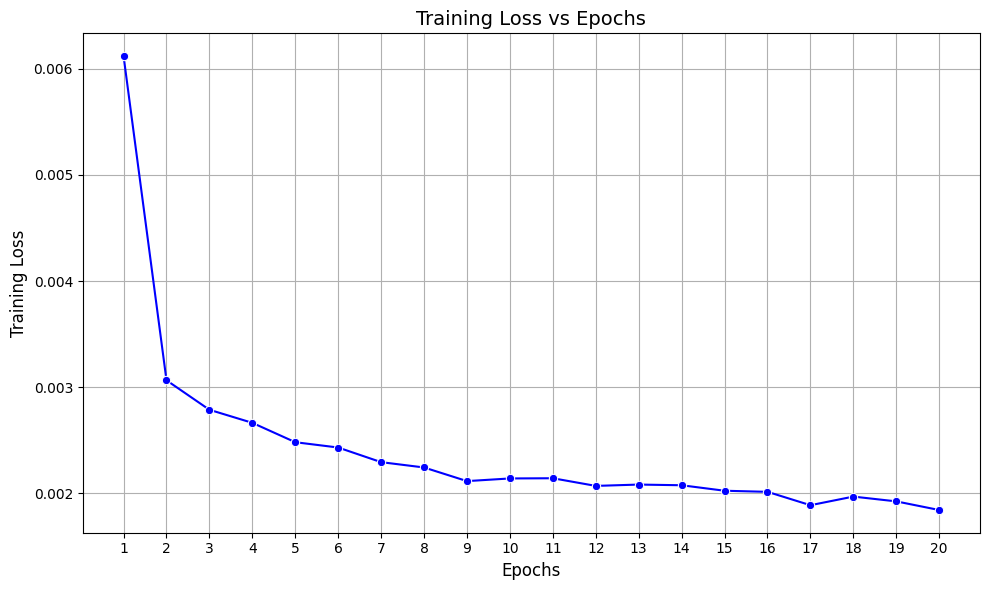

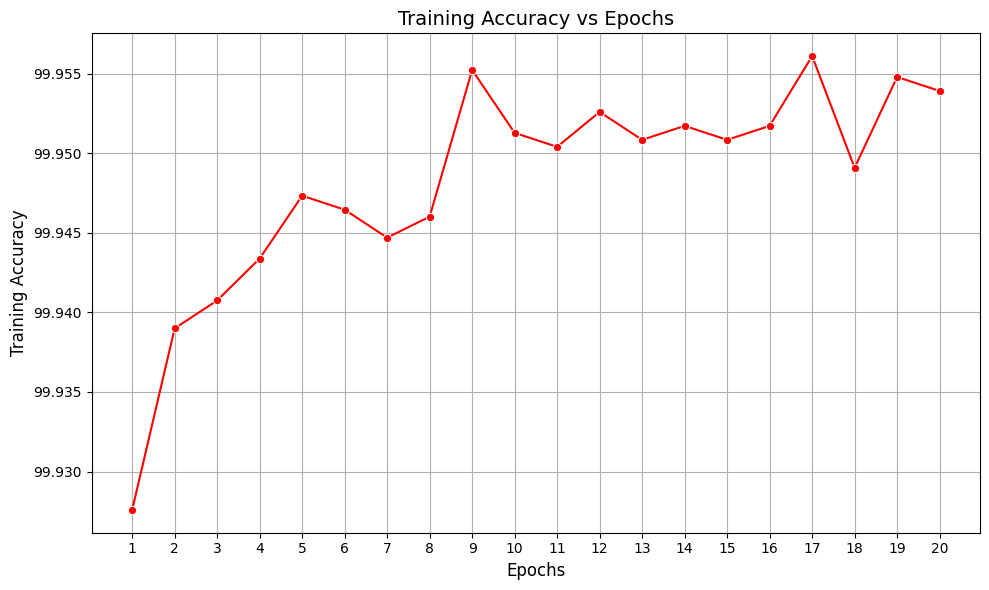

In [12]:
print_analysis(train_lossses, title='Training Loss vs Epochs', xlabel='Epochs', ylabel='Training Loss', color='blue')
print_analysis(train_accuracies, title='Training Accuracy vs Epochs', xlabel='Epochs', ylabel='Training Accuracy', color='red')

In [16]:
print("\nTraining Hybrid Model with sample Dataset:")
sampled_train_loader = sample_from_train(X_train, y_train, sample_size_for_each_class=5, batch_size=32)
model_hybrid = HybridClassifier(input_dim, hybrid=True, epochs=10, batch_size=32, learning_rate=0.001, n_qubits=n_qubits, n_classes=2, n_layers=2)
train_lossses, train_accuracies = model_hybrid.train_with_scheduler(sampled_train_loader, print_loss=True, print_time=True)
test_loss, test_accuracy = model_hybrid.evaluate(test_loader, loss_fn=nn.CrossEntropyLoss())

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


Training Hybrid Model with sample Dataset:
Epoch 1
--------------------------
Training Loss: 0.760539 

Epoch 2
--------------------------
Training Loss: 0.739828 

Epoch 3
--------------------------
Training Loss: 0.735411 

Epoch 4
--------------------------
Training Loss: 0.722210 

Epoch 5
--------------------------
Training Loss: 0.707983 

Epoch 6
--------------------------
Training Loss: 0.699172 

Epoch 7
--------------------------
Training Loss: 0.695352 

Epoch 8
--------------------------
Training Loss: 0.692201 

Epoch 9
--------------------------
Training Loss: 0.688669 

Epoch 10
--------------------------
Training Loss: 0.686372 

Training took 0.03 minutes.



RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

In [21]:
print("\nTraining Hybrid Model with sample Dataset:")
sampled_train_loader = sample_from_train(X_train, y_train, sample_size_for_each_class=10, batch_size=32)
model_hybrid = Classifier(input_dim, hybrid=True, epochs=10, batch_size=32, learning_rate=0.001, n_qubits=n_qubits, n_classes=2, n_layers=2)
model_hybrid.train_with_scheduler(sampled_train_loader)
model_hybrid.test_model(test_loader, loss_fn=nn.CrossEntropyLoss())


Training Hybrid Model with sample Dataset:
Epoch 1
--------------------------
Training Loss: 0.672480 

Epoch 2
--------------------------
Training Loss: 0.635620 

Epoch 3
--------------------------
Training Loss: 0.591567 

Epoch 4
--------------------------
Training Loss: 0.553049 

Epoch 5
--------------------------
Training Loss: 0.527329 

Epoch 6
--------------------------
Training Loss: 0.496430 

Epoch 7
--------------------------
Training Loss: 0.470478 

Epoch 8
--------------------------
Training Loss: 0.447795 

Epoch 9
--------------------------
Training Loss: 0.425119 

Epoch 10
--------------------------
Training Loss: 0.404766 

Training took 0.07 minutes.

Accuracy: 40.38%
Avg loss: 0.701183 



(0.7011825544053688, tensor(40.3811, device='cuda:0'))

In [ ]:
print("\nTraining Hybrid Model with sample Dataset:")
sampled_train_loader = sample_from_train(X_train, y_train, sample_size_for_each_class=10, batch_size=32)
model_hybrid = Classifier(input_dim, hybrid=True, epochs=10, batch_size=32, learning_rate=0.001, n_qubits=n_qubits, n_classes=2, n_layers=2)
model_hybrid.train_with_scheduler(sampled_train_loader)
model_hybrid.test_model(test_loader, loss_fn=nn.CrossEntropyLoss())

In [ ]:
print("\nTraining Hybrid Model with full Dataset:")
model_hybrid = Classifier(input_dim, hybrid=True, epochs=10, batch_size=32, learning_rate=0.001, n_qubits=n_qubits, n_classes=2, n_layers=2)
model_hybrid.train_with_scheduler(train_loader)
model_hybrid.test_model(test_loader, loss_fn=nn.CrossEntropyLoss())


Training Hybrid Model with full Dataset:
Epoch 1
--------------------------


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x798caee4cd30>>
Traceback (most recent call last):
  File "/home/abdelrahmanelsayed/PC/Quantum_Abdo/.venv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
